In [ ]:
import os
from PIL import Image

base_input_labels = "../dataset/labels"
base_input_images = "../dataset/images"
base_output_labels = "yolo_dataset/labels"
base_output_images = "yolo_dataset/images"

target_size = (640, 480)

def resize_images(split, target_size=(640, 480)):
    input_dir = os.path.join(base_input_images, split, "grayscale_wholeImage")
    output_dir = os.path.join(base_output_images, split, "grayscale_wholeImage")
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                img = Image.open(input_path)
                img_resized = img.resize(target_size)
                img_resized.save(output_path)
                print(f"[✓] Resized: {filename}")
            except Exception as e:
                print(f"[✗] Error resizing {filename}: {e}")

def convert_bbox_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height):
    # Clip bounding box to image bounds
    x_min = max(0, min(x_min, img_width - 1))
    x_max = max(0, min(x_max, img_width - 1))
    y_min = max(0, min(y_min, img_height - 1))
    y_max = max(0, min(y_max, img_height - 1))

    x_center = (x_min + x_max) / 2.0 / img_width
    y_center = (y_min + y_max) / 2.0 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return x_center, y_center, width, height

def process_split(split):
    input_label_dir = os.path.join(base_input_labels, split, "boundingBoxes_wholeImage")
    input_image_dir = os.path.join(base_input_images, split, "grayscale_wholeImage")
    output_label_dir = os.path.join(base_output_labels, split, "grayscale_wholeImage")
    os.makedirs(output_label_dir, exist_ok=True)

    if not os.path.exists(input_label_dir):
        print(f"[Warning] Input label directory does not exist: {input_label_dir}")
        return

    for filename in os.listdir(input_label_dir):
        if not filename.endswith(".txt"):
            continue

        input_label_path = os.path.join(input_label_dir, filename)
        input_image_path = os.path.join(input_image_dir, filename.replace('.txt', '.png'))  # or .jpg/.jpeg if needed
        output_label_path = os.path.join(output_label_dir, filename)

        # Load original image size
        try:
            img = Image.open(input_image_path)
            img_width, img_height = img.size
        except Exception as e:
            print(f"[✗] Error reading image {input_image_path}: {e}")
            continue

        with open(input_label_path, 'r') as infile, open(output_label_path, 'w') as outfile:
            for line in infile:
                cls, x_min, y_min, x_max, y_max = map(float, line.strip().split(','))
                cls = int(cls) - 1  # convert to 0-based
                x, y, w, h = convert_bbox_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height)
                outfile.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

        print(f"[✓] Converted: {filename}")

# Resize and convert
for split in ['train', 'test']:
    resize_images(split, target_size=target_size)
    process_split(split)


In [66]:
def filter_files(keep, dir):
    if not dir.exists():
        raise Exception("Error, directory doesnt exist")

    for file in dir.iterdir():
        if not file.name.endswith(keep):
            try:
                os.remove(file) 
                print(f'Removed: {file}')
            except Exception as e:
                print(f'Error removing {file}: {e}')



In [ ]:
from pathlib import Path

image_dirs = [
    Path('yolo_dataset/images/train/grayscale_wholeImage'),
    Path('yolo_dataset/images/test/grayscale_wholeImage')
]

label_dirs = [
    Path('yolo_dataset/labels/train/grayscale_wholeImage'),
    Path('yolo_dataset/labels/test/grayscale_wholeImage')
]

for image_dir in image_dirs:
    filter_files(keep='png', dir=image_dir)

for label_dir in label_dirs:
    filter_files(keep='txt', dir=label_dir)

In [1]:
!cd yolov5 && python train.py --data data.yaml --epochs 56 --weights yolov5l.pt --cfg yolov5l.yaml --batch-size 8 --img 640 --image-weights  

train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=56, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=True, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
remote: Enumerating objects: 1, done.
remote: Total 1 (delta 0), reused 0 (delta 0), pack-reused 1 (from 1)
Unpacking objects: 100% (1/1), 1.17 KiB | 1.17 MiB/s, done.
From https://github.com/ultralytics/yolov5
   a493afe1..cd44191c  master     -> origin/master
github: ⚠️ YOLOv5 is out of date by 1 commit. Use 'gi

In [2]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp12/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/abdulbari/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-6-4 Python-3.12.7 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46124433 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


In [3]:
!cd yolov5 && python val.py --data data.yaml --weights runs/train/exp11/weights/best.pt --task test

val: data=data.yaml, weights=['runs/train/exp11/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.12.7 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46124433 parameters, 0 gradients, 107.7 GFLOPs
test: Scanning /home/abdulbari/uni/seminar/yolo1/yolo_dataset/labels/test/graysc
                 Class     Images  Instances          P          R      mAP50   
                   all        500       1133      0.952      0.862      0.948      0.829
           infant_seat        500        250      0.984      0.742      0.967      0.862
            child_seat        500        266      0.869      0.917      0.946        0.8
                pers

/home/abdulbari/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 480x640 1 child_seat, 1 person, 1 object
Speed: 63.1ms pre-process, 74.0ms inference, 139.8ms NMS per image at shape (1, 3, 480, 640)


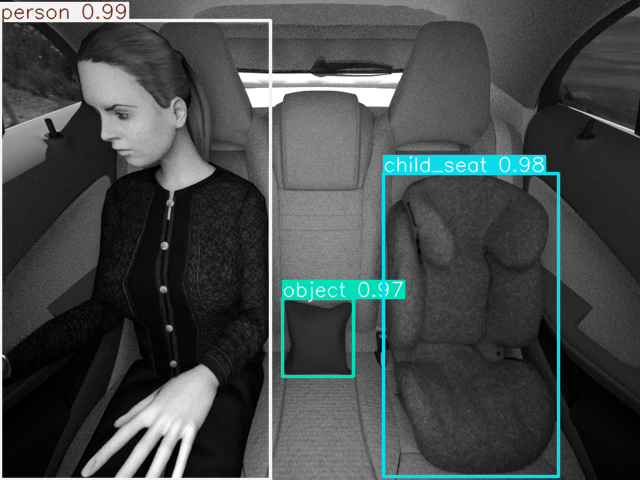

In [4]:
import os

image = os.path.join('yolo_dataset', 'images', 'test', 'grayscale_wholeImage', 'aclass_test_imageID_108_GT_3_4_6.png')

result = model(image)
result.print()

from PIL import Image
Image.fromarray(result.render()[0]).show()